Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s - loss: 191.4029 - val_loss: 173.3953
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 171.2819 - val_loss: 169.7923
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 167.7215 - val_loss: 166.8694
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 165.3770 - val_loss: 164.3822
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 163.9286 - val_loss: 163.3929
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 162.8987 - val_loss: 162.6071
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 162.0510 - val_loss: 161.7084
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 161.2903 - val_loss: 161.4766
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 160.6084 - val_loss: 160.7676
Epoch 10/50
60000/60000 [==============================] -

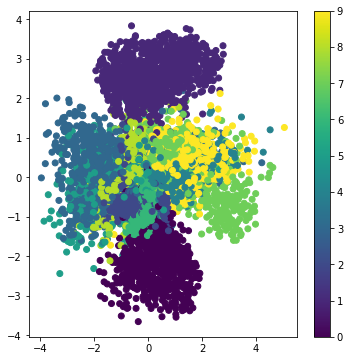

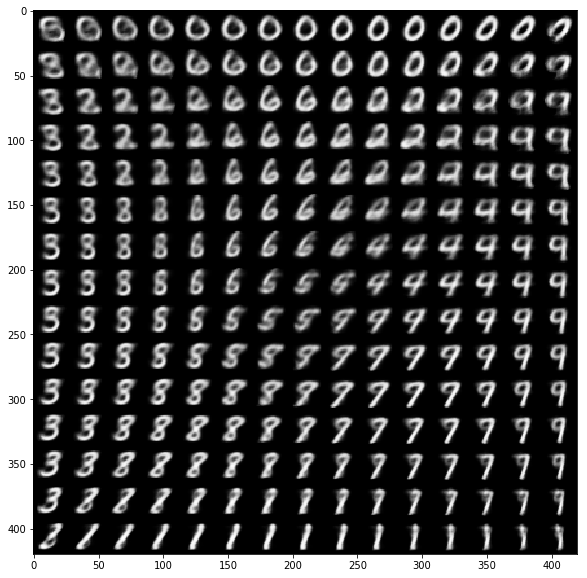

In [5]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)


batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)


loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
vae.compile(optimizer='rmsprop', loss=[zero_loss])


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s - loss: 190.5498 - val_loss: 171.1571
Epoch 2/5
60000/60000 [==============================] - 2s - loss: 169.4162 - val_loss: 167.8291
Epoch 3/5
60000/60000 [==============================] - 2s - loss: 166.7843 - val_loss: 165.9774
Epoch 4/5
60000/60000 [==============================] - 2s - loss: 164.8127 - val_loss: 164.1473
Epoch 5/5
60000/60000 [==============================] - 2s - loss: 163.2013 - val_loss: 162.8782


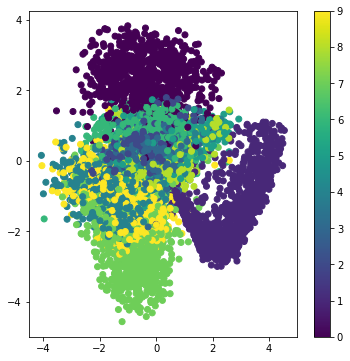

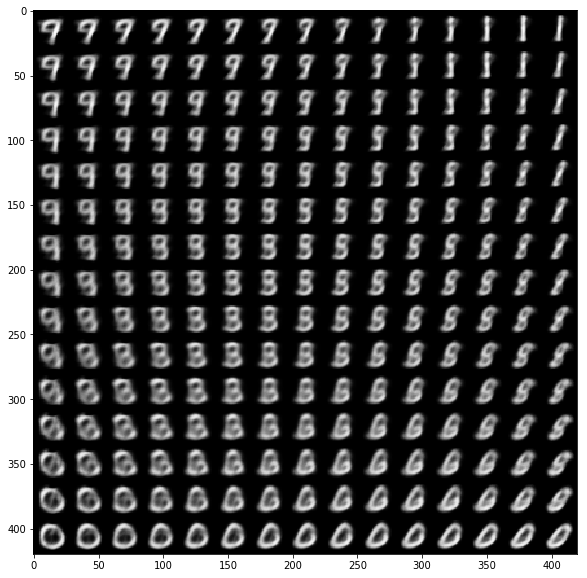

In [12]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

class Hyper(object):
    batch_size = 100
    original_dim = 784
    latent_dim = 2
    intermediate_dim = 256
#     epochs = 50
    epochs = 5
    epsilon_std = 1.0


class MnistVae(object):
    def __init__(self, h):
        self.h = h
        x = Input(batch_shape=(self.h.batch_size, self.h.original_dim))
        h = Dense(self.h.intermediate_dim, activation='relu')(x)
        z_mean = Dense(self.h.latent_dim)(h)
        z_log_var = Dense(self.h.latent_dim)(h)
        
        _original_dim = self.h.original_dim
        _batch_size = self.h.batch_size
        _latent_dim = self.h.latent_dim
        _epsilon_std = self.h.epsilon_std
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(_batch_size, _latent_dim), mean=0.,
                                      stddev=_epsilon_std)
            return z_mean + K.exp(z_log_var / 2) * epsilon

        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.h.latent_dim,))([z_mean, z_log_var])

        # we instantiate these layers separately so as to reuse them later
        decoder_h = Dense(self.h.intermediate_dim, activation='relu')
        decoder_mean = Dense(self.h.original_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)


        # placeholder loss
        def zero_loss(y_true, y_pred):
            return K.zeros_like(y_pred)


        # Custom loss layer
        class CustomVariationalLayer(Layer):
            def __init__(self, **kwargs):
                self.is_placeholder = True
                super(CustomVariationalLayer, self).__init__(**kwargs)

            def vae_loss(self, x, x_decoded_mean):
                xent_loss = _original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
                kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
                return K.mean(xent_loss + kl_loss)

            def call(self, inputs):
                x = inputs[0]
                x_decoded_mean = inputs[1]
                loss = self.vae_loss(x, x_decoded_mean)
                self.add_loss(loss, inputs=inputs)
                # we don't use this output, but it has to have the correct shape:
                return K.ones_like(x)



        loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
        self.vae = Model(x, [loss_layer])
        self.vae.compile(optimizer='rmsprop', loss=[zero_loss])


        # build a model to project inputs on the latent space
        self.encoder = Model(x, z_mean)

        # build a digit generator that can sample from the learned distribution
        decoder_input = Input(shape=(self.h.latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        self.generator = Model(decoder_input, _x_decoded_mean)

h = Hyper()
model = MnistVae(h)
        
model.vae.fit(x_train, x_train,
        shuffle=True,
        epochs=h.epochs,
        batch_size=h.batch_size,
        validation_data=(x_test, x_test))


# display a 2D plot of the digit classes in the latent space
x_test_encoded = model.encoder.predict(x_test, batch_size=h.batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = model.generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()